In [1]:
import torch
import torch.nn.functional as F

import torchsde
import math
import matplotlib.pyplot as plt

import numpy as np

from tqdm.notebook import tqdm

from torch import _vmap_internals

import pandas as pd

In [2]:
from cfollmer.objectives import log_g, relative_entropy_control_cost, stl_relative_entropy_control_cost
from cfollmer.sampler_utils import FollmerSDE
from cfollmer.trainers import basic_batched_trainer

# The Model

\begin{align}
\theta &\sim \mathcal{N}(\theta | 0, \sigma_w^2 \mathbb{I}) \\
y_i | x_i, \theta &\sim  \mathrm{Bernouli}\left[\mathrm{NN}_{\theta}\left(x_i \right)\right]
\end{align}

We want samples from $p(\theta | \{(y_i, x_i)\})$. Note $f(x; \theta)$ is a neural net with params $\theta$

## Loading the iris dataset

In [3]:
a9a_train = pd.read_csv("../data/a9a.csv", header=None)
a9a_test = pd.read_csv("../data/a9a_t.csv", header=None)

In [14]:
X_train, y_train = a9a_test.values[:,:-1],  a9a_test.values[:,-1]
X_test, y_test = a9a_test.values[:,:-1],  a9a_test.values[:,-1]

X_train = np.concatenate((X_train, np.ones((X_train.shape[0],1))), axis=1)
X_test = np.concatenate((X_test, np.ones((X_test.shape[0],1))), axis=1)

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train, X_test, y_train, y_test = \
    torch.tensor(X_train, dtype=torch.float32, device=device), \
    torch.tensor(X_test, dtype=torch.float32, device=device), \
    torch.tensor(y_train, dtype=torch.float32, device=device), \
    torch.tensor(y_test, dtype=torch.float32, device=device) 

In [16]:
X_train.shape

torch.Size([16281, 124])

$$\DeclareMathOperator*{\argmin}{arg\,min}$$
$$\def\E{{\mathbb{E}}}$$
$$\def\rvu{{\mathbf{u}}}$$
$$\def\rvTheta{{\bm{\Theta}}}$$
$$\def\gU{{\mathcal{U}}}$$
$$\def\mX{{\mathbf{X}}}$$

## Controlled Schrodinger Follmer Sampler

The objevtive we are trying to implement is:

\begin{align}
  \mathbf{u}_t^{*}=  \argmin_{\rvu_t \in \mathcal{U}}\mathbb{E}\left[\frac{1}{2\gamma}\int_0^1||\rvu(t, \Theta_t)||^2 dt - \ln\left(\frac{ p(\mX | \Theta_1)p(\Theta_1)}{\mathcal{N}(\Theta_1|\mathbf{0}, \gamma \mathbb{I} )}\right)\right] \
\end{align}

Where:
\begin{align}
d\Theta_t = \rvu(t, \Theta_t)dt + \sqrt{\gamma} dB_t
\end{align}

To do so we use the EM discretisation.

In [17]:
import torch.nn.functional as F


class OnedRegressionForwardNet(object):
    
    def __init__(
        self, input_dim=1, output_dim=1, depth=None,
        width=20, width_seq=None, device="cpu", activation=F.relu
    ):
        
        self.device = device
        self.output_dim = output_dim
        self.input_dim = input_dim 
        self.activation = activation
        
        self.depth = depth
        if not self.depth:
            self.depth = 1
        if not width_seq:
            self.width = width
            self.width_seq = [self.width] * (self.depth + 1)
            self.shapes = [(self.width_seq[i-1], self.width_seq[i])  for i in range(1,self.depth)]
            self.shapes += [(self.width_seq[-1], self.output_dim)]
            self.shapes = [(self.input_dim, self.width_seq[0])] + self.shapes
        
        self.dim = sum([wx * wy + wy for wx, wy in self.shapes])
        
    def forward(self, x, Θ):
        index = 0
        n, d = x.shape
        
#         dim_bl =  sum([wx * wy + wy for wx, wy in self.shapes[:-1]])
#         Θ[:dim_bl] = (Θ[:dim_bl] - Θ[:dim_bl].mean()) / Θ[:dim_bl].std()
#         σ_Θ, μ_Θ = Θ.std(), Θ.mean()
#         Θ = (Θ - μ_Θ) / σ_Θ

        for wx, wy in self.shapes[:-1]:
            x = F.linear(
                x,
                Θ[index: index + wx * wy].reshape(wy, wx),
                Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy)
            )
            x = self.activation(x)
            index += wx * wy  + wy
        wx, wy = self.shapes[-1]
        x = F.linear(
            x,
            Θ[index: index + wx * wy].reshape(wy, wx), #* σ_Θ + μ_Θ,
            Θ[index + wx * wy: index + wx * wy + wy].reshape(1,wy) # * σ_Θ + μ_Θ
        )
        return x.to(self.device)
    
    def map_forward(self, x, Θ):
        preds_func = lambda θ: self.forward(x, θ)
        batched_preds = torch._vmap_internals.vmap(preds_func)
        preds = torch.hstack(list(map(preds_func, Θ)))
        return preds
        

In [21]:
dim = X_train.shape[1]

net = OnedRegressionForwardNet(
    dim,1, device=device, depth=1, width=30, activation=F.tanh
)


def gaussian_prior(Θ, σ_w=1.8):
    """
    Logistic regresion bayesian prior
    """
    return -0.5 * (Θ**2).sum(axis=1) / σ_w


# def log_likelihood_vmap(Θ, X, y):
#     """
#     Hoping this implementation is less buggy / faster
    
#     still feels a bit slow.
#     """
#     logits = X.mm(Θ.T)
    
#     pos_weights = torch.ones(logits.shape[0], device=device)
         
#     loss = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
    
#     # TODO: Double check this is right, changed to a minus sign here
#     loss_ = lambda x: -1.0 * loss(x, y)
    
#     batched_loss =  torch._vmap_internals.vmap(loss_)

#     return batched_loss(logits.T)


def log_likelihood_vmap_nn(Θ, X, y, net=net):
    """
    Hoping this implementation is less buggy / faster
    
    still feels a bit slow.
    """
    pos_weights = torch.ones(X.shape[0], device=device)
    
    def loss(θ):
        preds = net.forward(X, θ)
        bce = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights, reduction="sum")
        ll_bcs = -1.0 * bce(preds.reshape(-1), y.reshape(-1))
        return ll_bcs
    
    batched_loss =  torch._vmap_internals.vmap(loss)

    return batched_loss(Θ)

In [22]:
net.dim

3781

In [23]:
γ = 0.2
Δt=0.05

dim= net.dim

sde, losses = basic_batched_trainer(
    γ, Δt, gaussian_prior, log_likelihood_vmap_nn, dim, X_train, y_train,
    method="euler", stl=True, adjoint=False, optimizer=None,
    num_steps=400, batch_size_data=X_train.shape[0], batch_size_Θ=20,
    batchnorm=True, device=device, lr=0.001
)

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


<ipython-input-21-d43ec0b2bbc9>:49: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss)
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.700049638748169



Widget Javascript not detected.  It may not be installed or enabled properly.


0.662398636341095



Widget Javascript not detected.  It may not be installed or enabled properly.


0.6285812854766846



Widget Javascript not detected.  It may not be installed or enabled properly.


0.563338041305542



Widget Javascript not detected.  It may not be installed or enabled properly.


0.544550359249115



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5513421893119812



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5757287740707397



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5372978448867798



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5109886527061462



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5093045830726624



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5194924473762512



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5157961249351501



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5141147375106812



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5039637088775635



Widget Javascript not detected.  It may not be installed or enabled properly.


0.560758113861084



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5295371413230896



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5281153917312622



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5544273853302002



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5346985459327698



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5276424288749695



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5472694039344788



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5279454588890076



Widget Javascript not detected.  It may not be installed or enabled properly.


0.506980299949646



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5391902327537537



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5376709699630737



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5165536403656006



Widget Javascript not detected.  It may not be installed or enabled properly.


0.528659462928772



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5199503898620605



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5153163075447083



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5121948719024658



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5597206950187683



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5001117587089539



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5408616662025452



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5293005704879761



Widget Javascript not detected.  It may not be installed or enabled properly.


0.4981538653373718



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5056326389312744



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5124948024749756



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5232334136962891



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5182971358299255



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5250799059867859



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5068316459655762



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5362134575843811



Widget Javascript not detected.  It may not be installed or enabled properly.


0.4961320757865906



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5210354924201965



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5518255233764648



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5210007429122925



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5350130796432495



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5233879685401917



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5086269378662109



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5321738719940186



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5262913703918457



Widget Javascript not detected.  It may not be installed or enabled properly.


0.503900408744812



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5118324756622314



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5237694978713989



Widget Javascript not detected.  It may not be installed or enabled properly.


0.543700635433197



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5198143124580383



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5561037659645081



Widget Javascript not detected.  It may not be installed or enabled properly.


0.521027147769928



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5489436388015747



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5303088426589966



Widget Javascript not detected.  It may not be installed or enabled properly.


0.522561252117157



Widget Javascript not detected.  It may not be installed or enabled properly.


0.4988258183002472



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5322762727737427



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5302907228469849



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5296680927276611



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5118178129196167



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5455877780914307



Widget Javascript not detected.  It may not be installed or enabled properly.


0.519895076751709



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5415804386138916



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5306922197341919



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5180981755256653



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5086969137191772



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5408182740211487



Widget Javascript not detected.  It may not be installed or enabled properly.


0.513454794883728



Widget Javascript not detected.  It may not be installed or enabled properly.


0.503429651260376



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5458343029022217



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5187035799026489



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5579572319984436



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5481925010681152



Widget Javascript not detected.  It may not be installed or enabled properly.


0.519912838935852



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5206828713417053



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5459974408149719



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5256693363189697



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5260250568389893



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5118626952171326



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5123533010482788



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5312269330024719



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5110176205635071



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5387591123580933



Widget Javascript not detected.  It may not be installed or enabled properly.


0.520278811454773



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5104988217353821



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5303032398223877



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5187888741493225



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5226543545722961



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5110740065574646



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5213102102279663



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5290257334709167



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5236131548881531



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5118866562843323



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5302259922027588



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5213344693183899



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5148552656173706



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5446868538856506



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5326457619667053



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5123339891433716



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5372818112373352



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5555642247200012



Widget Javascript not detected.  It may not be installed or enabled properly.


0.524503231048584



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5505693554878235



Widget Javascript not detected.  It may not be installed or enabled properly.


0.541400671005249



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5262966752052307



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5369642972946167



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5344951152801514



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5425915718078613



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5224171876907349



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5090983510017395



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5168982744216919



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5089961290359497



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5311559438705444



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5334371328353882



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5283929109573364



Widget Javascript not detected.  It may not be installed or enabled properly.


0.505607008934021



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5340371131896973



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5058539509773254



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5332098007202148



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5670903921127319



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5269789695739746



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5217730402946472



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5435317158699036



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5355754494667053



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5253176093101501



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5124154090881348



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5316440463066101



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5176383256912231



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5290858149528503



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5349430441856384



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5249817967414856



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5375614762306213



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5619426369667053



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5148194432258606



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5303031206130981



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5127230286598206



Widget Javascript not detected.  It may not be installed or enabled properly.


0.537528932094574



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5184773802757263



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5390555262565613



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5105105638504028



Widget Javascript not detected.  It may not be installed or enabled properly.


0.550352931022644



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5428490042686462



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5514251589775085



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5467982888221741



Widget Javascript not detected.  It may not be installed or enabled properly.


0.529474139213562



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5311388373374939



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5483253002166748



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5203043818473816



Widget Javascript not detected.  It may not be installed or enabled properly.


0.561026394367218



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5508030652999878



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5281422734260559



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5270676016807556



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5496209859848022



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5336510539054871



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5147662162780762



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5111613869667053



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5364357829093933



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5230539441108704



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5138993859291077



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5506067872047424



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5308375358581543



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5189088582992554



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5134490728378296



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5412908792495728



Widget Javascript not detected.  It may not be installed or enabled properly.


0.538463830947876



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5314251780509949



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5479865074157715



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5228942632675171



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5385389924049377



Widget Javascript not detected.  It may not be installed or enabled properly.


0.529815673828125



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5585618019104004



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5116423964500427



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5024263858795166



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5313092470169067



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5321255326271057



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5227327346801758



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5330911874771118



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5160326957702637



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5061869621276855



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5258414149284363



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5182268023490906



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5473425984382629



Widget Javascript not detected.  It may not be installed or enabled properly.


0.538750410079956



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5258421897888184



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5526896119117737



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5651005506515503



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5656349062919617



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5496141910552979



Widget Javascript not detected.  It may not be installed or enabled properly.


0.546699047088623



Widget Javascript not detected.  It may not be installed or enabled properly.


0.545761227607727



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5158333778381348



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5572309494018555



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5453376770019531



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5372298955917358



Widget Javascript not detected.  It may not be installed or enabled properly.


0.529530942440033



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5400058627128601



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5105978846549988



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5331239700317383



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5293394923210144



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5325341820716858



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5089815855026245



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5115810632705688



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5365487933158875



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5378729104995728



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5248284935951233



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5321916341781616



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5199572443962097



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5224857926368713



Widget Javascript not detected.  It may not be installed or enabled properly.


0.572691798210144



Widget Javascript not detected.  It may not be installed or enabled properly.


0.507401168346405



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5584980845451355



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5383518934249878



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5588573217391968



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5473071932792664



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5315594673156738



Widget Javascript not detected.  It may not be installed or enabled properly.


0.515563428401947



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5445484519004822



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5307307839393616



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5258408188819885



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5177236795425415



Widget Javascript not detected.  It may not be installed or enabled properly.


0.525152325630188



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5272644758224487



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5406630039215088



Widget Javascript not detected.  It may not be installed or enabled properly.


0.521020770072937



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5271861553192139



Widget Javascript not detected.  It may not be installed or enabled properly.


0.572348415851593



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5105270147323608



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5173806548118591



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5115780830383301



Widget Javascript not detected.  It may not be installed or enabled properly.


0.515789806842804



Widget Javascript not detected.  It may not be installed or enabled properly.


0.532858669757843



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5351739525794983



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5454066395759583



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5417417287826538



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5230737924575806



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5366917848587036



Widget Javascript not detected.  It may not be installed or enabled properly.


0.537132740020752



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5310506820678711



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5335812568664551



Widget Javascript not detected.  It may not be installed or enabled properly.


0.543609619140625



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5384543538093567



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5306516289710999



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5207423567771912



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5166047215461731



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5309721231460571



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5210066437721252



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5176055431365967



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5287542343139648



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5441844463348389



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5283578038215637



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5466856360435486



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5703139901161194



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5524842143058777



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5212002396583557



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5271804928779602



Widget Javascript not detected.  It may not be installed or enabled properly.


0.523201048374176



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5739039182662964



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5157790184020996



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5338640213012695



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5269089937210083



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5418996214866638



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5690917372703552



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5145819783210754



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5276670455932617



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5687049627304077



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5397537350654602



Widget Javascript not detected.  It may not be installed or enabled properly.


0.538719117641449



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5293475985527039



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5529373288154602



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5471295714378357



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5287078619003296



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5069273710250854



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5324652194976807



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5312864780426025



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5289486646652222



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5405411124229431



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5182714462280273



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5382323861122131



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5156810879707336



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5375568866729736



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5150583386421204



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5500407218933105



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5645737648010254



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5411679148674011



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5536608695983887



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5397393107414246



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5287182331085205



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5369895100593567



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5128507018089294



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5108345746994019



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5192164182662964



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5429308414459229



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5472054481506348



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5423840284347534



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5195689797401428



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5368809103965759



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5198819041252136



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5435242056846619



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5205742120742798



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5383563041687012



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5533638000488281



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5471785664558411



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5467309951782227



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5408194065093994



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5460487008094788



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5482516288757324



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5277684926986694



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5212676525115967



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5119382739067078



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5303394198417664



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5301753282546997



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5397438406944275



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5209760665893555



Widget Javascript not detected.  It may not be installed or enabled properly.


0.557262659072876



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5382951498031616



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5211556553840637



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5438239574432373



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5115615129470825



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5574619770050049



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5265846848487854



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5601107478141785



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5267784595489502



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5454650521278381



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5380311608314514



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5460329055786133



Widget Javascript not detected.  It may not be installed or enabled properly.


0.49897506833076477



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5306568145751953



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5070066452026367



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5211689472198486



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5458170771598816



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5207164287567139



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5353133678436279



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5575109124183655



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5346576571464539



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5143784284591675



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5102965235710144



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5274181365966797



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5167191624641418



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5322515368461609



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5341014862060547



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5242853164672852



Widget Javascript not detected.  It may not be installed or enabled properly.


0.541894257068634



Widget Javascript not detected.  It may not be installed or enabled properly.


0.521759569644928



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5436187386512756



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5101233124732971



Widget Javascript not detected.  It may not be installed or enabled properly.


0.512161374092102



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5121918320655823



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5066248178482056



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5058911442756653



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5269038081169128



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5274350047111511



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5180084109306335



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5363336801528931



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5224863886833191



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5276507139205933



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5228695273399353



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5294878482818604



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5288362503051758



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5350825786590576



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5345226526260376



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5243460536003113



Widget Javascript not detected.  It may not be installed or enabled properly.


0.49217045307159424



Widget Javascript not detected.  It may not be installed or enabled properly.


0.558584988117218



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5365076065063477



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5071552991867065



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5216706395149231



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5341528058052063



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5155674815177917



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5440436601638794



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5141465067863464



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5162317156791687



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5021609663963318



Widget Javascript not detected.  It may not be installed or enabled properly.


0.515519917011261



Widget Javascript not detected.  It may not be installed or enabled properly.


0.502032995223999



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5309877991676331



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5173755288124084



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5077744126319885



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5058718323707581



Widget Javascript not detected.  It may not be installed or enabled properly.


0.512808620929718


Widget Javascript not detected.  It may not be installed or enabled properly.


0.5207753777503967



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5069226622581482



Widget Javascript not detected.  It may not be installed or enabled properly.


0.527426540851593



Widget Javascript not detected.  It may not be installed or enabled properly.


0.545810341835022



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5369439721107483



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5496974587440491



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5495895743370056



Widget Javascript not detected.  It may not be installed or enabled properly.


0.528942346572876



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5246151089668274



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5085657238960266



Widget Javascript not detected.  It may not be installed or enabled properly.


0.522546112537384



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5211523771286011



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5475758910179138



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5052774548530579



Widget Javascript not detected.  It may not be installed or enabled properly.


0.5359182357788086




In [9]:
losses

[tensor(0.6143),
 tensor(0.5484),
 tensor(0.4473),
 tensor(0.4503),
 tensor(0.3647),
 tensor(0.3416),
 tensor(0.3480),
 tensor(0.2825),
 tensor(0.2198),
 tensor(0.2083),
 tensor(0.2142),
 tensor(0.1416),
 tensor(0.1281),
 tensor(0.0595),
 tensor(0.0805),
 tensor(0.0861),
 tensor(-0.0061),
 tensor(0.0094),
 tensor(0.0166),
 tensor(-0.0360),
 tensor(-0.0466),
 tensor(0.0088),
 tensor(-0.0360),
 tensor(0.0130),
 tensor(0.0071),
 tensor(-0.1439),
 tensor(-0.0752),
 tensor(0.0112),
 tensor(-0.0639),
 tensor(-0.1037),
 tensor(0.0251),
 tensor(-0.0543),
 tensor(-0.0793),
 tensor(-0.1533),
 tensor(-0.0384),
 tensor(-0.0619),
 tensor(-0.0315),
 tensor(0.0054),
 tensor(-0.1116),
 tensor(-0.0876),
 tensor(-0.0436),
 tensor(-0.1119),
 tensor(-0.0304),
 tensor(-0.0023),
 tensor(-0.0397),
 tensor(-0.0172),
 tensor(-0.0600),
 tensor(0.0299),
 tensor(0.0172),
 tensor(0.0073),
 tensor(-0.1107),
 tensor(0.0691),
 tensor(-0.0878),
 tensor(-0.0676),
 tensor(-0.0134),
 tensor(-0.0951),
 tensor(-0.0168),
 t

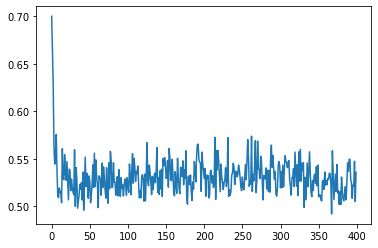

In [24]:
plt.plot(losses[:])

In [11]:
X_train.shape

torch.Size([80, 3])

In [25]:
t_size = int(math.ceil(1.0/Δt))
ts = torch.linspace(0, 1, t_size).to(device)
no_posterior_samples = 100
Θ_0 = torch.zeros((no_posterior_samples, net.dim)).to(device)

Θ_1 = torchsde.sdeint(sde, Θ_0, ts, dt=Δt)[-1,...]

(array([ 5.,  4.,  5., 11., 21., 18., 16., 11.,  6.,  3.]),
 array([-0.53464   , -0.4354493 , -0.3362586 , -0.23706786, -0.13787715,
        -0.03868644,  0.06050428,  0.15969498,  0.2588857 ,  0.35807642,
         0.45726714], dtype=float32),
 <BarContainer object of 10 artists>)

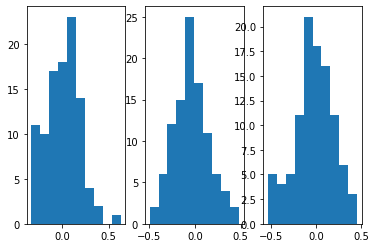

In [26]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.hist(Θ_1[:,0].cpu().detach().numpy())
ax2.hist(Θ_1[:,1].cpu().detach().numpy())
ax3.hist(Θ_1[:,2].cpu().detach().numpy())

In [27]:
def predc(X, Θ):
    return torch.vstack([torch.sigmoid(net.forward(X, θ)[None,...]) for θ in Θ]).mean(dim=0)

In [28]:
pred = predc(X_train, Θ_1)

In [29]:

((pred > 0.5).float().flatten()== y_train).float().mean()

tensor(0.7638, device='cuda:0')

In [30]:
pred_test = predc(X_test.float(), Θ_1)

In [31]:
((pred_test > 0.5).float().flatten() == y_test).float().mean()

tensor(0.7638, device='cuda:0')

## MAP Baseline

We run the point estimate approximation (Maximum a posteriori) to double check what the learned weights look like.  We get the  exact same training accuracy as with the controlled model and similarly large weights for the non bias weights. 

In [10]:
Θ_map = torch.zeros((1, dim), requires_grad=True, device=device)
optimizer_map = torch.optim.Adam([Θ_map], lr=0.05)
#     optimizer = torch.optim.LBFGS(gpr.parameters(), lr=0.01)

losses_map = []
num_steps = 1000
for i in tqdm(range(num_steps)):
    optimizer_map.zero_grad()

    if isinstance(optimizer_map, torch.optim.LBFGS):
        def closure_map():
            loss_map = log_likelihood_vmap()
            optimizer_map.zero_grad()
            loss_map.backward()
            return loss

        optimizer_map.step(closure_map)
        losses_map.append(closure_map().item())
    else:
        loss_map = -(log_likelihood_vmap(Θ_map, X_train, y_train) + gaussian_prior(Θ_map))
        optimizer_map.zero_grad()
        loss_map.backward()
        print(loss_map.item())
        optimizer_map.step()
        losses_map.append(loss_map.item())

Θ_map
pred_map = torch.sigmoid(X_train.mm(Θ_map.T)).mean(axis=1)
((pred_map < 0.5).float() == y_train).float().mean(), Θ_map

  0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\vargf\AppData\Local\Temp/ipykernel_2136/381526447.py:36: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  batched_loss =  torch._vmap_internals.vmap(loss_)


55.45177459716797
52.67886734008789
50.03776931762695
47.52959442138672
45.154483795166016
42.91158676147461
40.79913330078125
38.81449508666992
36.95428466796875
35.21445083618164
33.590423583984375
32.07719421386719
30.66946029663086
29.36173439025879
28.148420333862305
27.023902893066406
25.982643127441406
25.019207000732422
24.128328323364258
23.30495262145996
22.54424476623535
21.841611862182617
21.192726135253906
20.593515396118164
20.040164947509766
19.529117584228516
19.057064056396484
18.620927810668945
18.21786880493164
17.845247268676758
17.500642776489258
17.181812286376953
16.886699676513672
16.613401412963867
16.360179901123047
16.12543487548828
15.907696723937988
15.705615997314453
15.517951011657715
15.343571662902832
15.181438446044922
15.030595779418945
14.890161514282227
14.759340286254883
14.637393951416016
14.523643493652344
14.417470932006836
14.318305969238281
14.225625991821289
14.13895034790039
14.057838439941406
13.981886863708496
13.910720825195312
13.8439960

12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634765625
12.713775634

(tensor(0., device='cuda:0'),
 tensor([[ 0.0000,  2.4463, -2.1438]], device='cuda:0', requires_grad=True))